# Predicting Property Prices


## Import Libraries


In [1]:
# import libraries
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import geopandas as gpd
from shapely.geometry import shape, Point
import requests
import time
import warnings
import os
import glob

In [2]:
warnings.filterwarnings('ignore')

## Prepare Data


### Utility Variables


In [3]:
# relevant area codes
area_codes = [
    'E08000011', 'E08000012', 'E11000002', 'E08000014', 'E08000013',
    'E08000007', 'E06000007', 'E08000010', 'E08000015'
]

# Regions in Merseyside
regions = [
    'Prenton', 'Newton-Le-Willows', 'Birkenhead',
    'Wirral', 'Bootle', 'St Helens', 'Wallasey', 'Southport',
    'Prescot', 'Wigan', 'Widnes', 'Neston', 'Warrington',
    'Ellesmere Port', 'Wilmslow', 'Coniston', 'Stockport', 'Northwood',
    'Crewe', 'Winsford', 'Merseyside', 'Sefton', 'Wirral', 'Liverpool', 'Knowsley'
]

### Utility Functions


In [4]:
def standardise_column(df, column_name, mapping, remove_values=None, new_dtype='category'):
    """
    Standardise a DataFrame column by applying a mapping, optionally removing specific values, 
    and changing the data type.

    Parameters:
    df (DataFrame): The input DataFrame.
    column_name (str): The name of the column to standardize.
    mapping (dict): A dictionary mapping old values to new values.
    remove_values (list, optional): A list of values to remove from the column. Default is None.
    new_dtype (str, optional): The new data type for the column. Default is 'category'.

    Returns:
    DataFrame: The DataFrame with the standardized column.
    """

    # Optionally remove rows with specific values
    if remove_values:
        df = df[~df[column_name].isin(remove_values)]

    # Apply the mapping to replace old values with new values
    df[column_name] = df[column_name].replace(mapping).astype(new_dtype)

    return df

In [5]:
def rename_columns(df, new_column_names):
    """
    Rename the columns of a DataFrame using a provided list of new column names.

    Parameters:
    df (DataFrame): The input DataFrame whose columns need to be renamed.
    new_column_names (list): A list of new column names.

    Returns:
    DataFrame: The DataFrame with renamed columns.
    """
    # Check if the number of new column names matches the number of columns in the DataFrame
    if len(new_column_names) != df.shape[1]:
        raise ValueError(
            "The number of new column names must match the number of columns in the DataFrame.")

    # Rename the columns
    df.columns = new_column_names

    return df

### Import


#### Prices Paid Data


In [6]:
def bulk_lookup_postcodes(postcodes, batch_size=100):
    """
    Perform a bulk lookup for postcodes using the postcodes.io API.

    Parameters:
    postcodes (list): A list of postcodes to lookup.
    batch_size (int): The number of postcodes to include in each batch (max 100).

    Returns:
    dict: A dictionary mapping postcodes to their respective data, including latitude, longitude, and termination data if applicable.
    """
    url = "https://api.postcodes.io/postcodes"
    headers = {'Content-Type': 'application/json'}
    results = {}

    # Process the postcodes in batches
    for i in range(0, len(postcodes), batch_size):
        batch = postcodes[i:i+batch_size]
        data = {"postcodes": batch}

        response = requests.post(url, json=data, headers=headers)

        if response.status_code == 200:
            response_data = response.json()
            for result in response_data['result']:
                postcode = result['query']
                if result['result'] is not None:
                    results[postcode] = {
                        'longitude': result['result']['longitude'],
                        'latitude': result['result']['latitude'],
                        'is_terminated': False
                    }
                else:
                    # If the postcode is terminated, set to None and mark as terminated
                    results[postcode] = {
                        'longitude': None,
                        'latitude': None,
                        'is_terminated': True
                    }
        else:
            print(
                f"Failed to retrieve data for batch starting at {i}: {response.status_code}")
        time.sleep(0.1)  # To avoid rate limiting

    return results

In [7]:

def handle_terminated_postcodes(postcode_data):
    """
    Handle postcodes that are marked as terminated by checking the terminated postcode API.

    Parameters:
    postcode_data (dict): A dictionary of postcodes with their data, including termination status.

    Returns:
    dict: Updated dictionary with longitude and latitude for terminated postcodes if available.
    """
    terminated_postcodes = [postcode for postcode,
                            data in postcode_data.items() if data['is_terminated']]

    if not terminated_postcodes:
        return postcode_data  # No terminated postcodes to handle

    # Query terminated postcodes in bulk (max 100 at a time)
    url = "https://api.postcodes.io/terminated_postcodes"
    headers = {'Content-Type': 'application/json'}
    batch_size = 100

    for i in range(0, len(terminated_postcodes), batch_size):
        batch = terminated_postcodes[i:i+batch_size]
        data = {"postcodes": batch}

        response = requests.post(url, json=data, headers=headers)

        if response.status_code == 200:
            response_data = response.json()
            for result in response_data['result']:
                postcode = result['query']
                if result['result'] is not None:
                    postcode_data[postcode]['longitude'] = result['result']['longitude']
                    postcode_data[postcode]['latitude'] = result['result']['latitude']
                else:
                    # print(f"No data found for terminated postcode: {postcode}")
                    continue
        else:
            # print(
            #     f"Failed to retrieve data for terminated postcodes batch starting at {i}: {response.status_code}")
            continue
        time.sleep(0.1)  # To avoid rate limiting

    return postcode_data

In [8]:
def add_long_lat_columns(df, postcode_column='postcode'):
    """
    Add longitude and latitude columns to the DataFrame based on the postcode column using Bulk Lookup.

    Parameters:
    df (DataFrame): The input DataFrame with a postcode column.
    postcode_column (str): The name of the column containing postcodes. Default is 'postcode'.

    Returns:
    DataFrame: The DataFrame with added 'longitude' and 'latitude' columns.
    """
    postcodes = df[postcode_column].unique().tolist()
    postcode_data = bulk_lookup_postcodes(postcodes)
    postcode_data = handle_terminated_postcodes(postcode_data)

    # Map the longitude and latitude back to the original DataFrame
    df['longitude'] = df[postcode_column].map(
        lambda x: postcode_data[x]['longitude'])
    df['latitude'] = df[postcode_column].map(
        lambda x: postcode_data[x]['latitude'])

    return df

In [9]:
# define wrangle function for prices paid data
def wrangle_prices_paid(filepath):

    # import file
    df = pd.read_csv(filepath)

    # drop complete duplicates from house_data
    df = df.drop_duplicates()

    # add column names to df
    column_names = [
        'transaction_id', 'price', 'transfer_date',
        'postcode', 'property_type', 'is_old_or_new',
        'property_tenure', 'house_number_or_name', 'unit_number',
        'street', 'locality', 'town', 'district', 'county',
        'ppd_transaction_category', 'record_status_monthly_file_only'
    ]
    df = rename_columns(df, column_names)
    
    # convert transfer date to datetime
    df['transfer_date'] = pd.to_datetime(df['transfer_date'])
    
    # sort data by teansaction date
    df = df.sort_values('transfer_date', ascending=True)
    
    # filter data for freehold transactions in merseyside from 2013 to 2023
    df = df[(df['county'] == 'MERSEYSIDE') & (
        df['transfer_date'].dt.year >= 2013) & (df['transfer_date'].dt.year <= 2023)]

    # convert price to float type
    df['price'] = df['price'].astype(float)
    
    # remove outliers in price by values in the bottom and top 5% of properties
    low, high = df['price'].quantile([0.05, 0.95])
    mask_area = df['price'].between(low, high)
    df = df[mask_area]

    # convert ppd_transaction_category to category type
    df['ppd_transaction_category'] = df['ppd_transaction_category'].astype(
        'category')

    # define mappings for replacement
    property_type_mapping = {'T': 'Terraced', 'D': 'Detached', 'F': 'Flats/Maisonettes',
                             'S': 'Semi-Detached', 'O': 'Other'}
    old_or_new_mapping = {'N': 'Old', 'Y': 'New'}
    property_tenure_mapping = {'F': 'Freehold', 'L': 'Leasehold'}

    # standardize 'property_type' column
    df = standardise_column(df, 'property_type', property_type_mapping)
    # standardize 'is_old_or_new' column
    df = standardise_column(df, 'is_old_or_new', old_or_new_mapping)
    # standardize 'property_tenure' column and remove rows with 'U' before standardising
    df = standardise_column(df, 'property_tenure',
                            property_tenure_mapping, remove_values=['U'])

    # convert capital case columns to title case
    df['town'] = df['town'].str.title()
    df['district'] = df['district'].str.title()
    df['county'] = df['county'].str.title()
    
    # exclude rows with null postcode values
    df = df[~df['postcode'].isnull()]
    
    # created latitude and longitude columns
    df = add_long_lat_columns(df)

    # drop redundant columns
    df.drop(columns=['house_number_or_name', 'unit_number', 'locality',
                     'street', 'record_status_monthly_file_only', 'postcode'],
            inplace=True
            )

    return df

In [10]:
# Wrangle the prices paid data
prices_paid_data_df = wrangle_prices_paid(
    filepath="raw_data/prices_paid.csv")

# Display the first few rows to verify
prices_paid_data_df.head()

,transaction_id,price,transfer_date,property_type,is_old_or_new,property_tenure,town,district,county,ppd_transaction_category,longitude,latitude
18351985,{EF89E3A8-2BD1-4347-8B9B-F2CEEB2E62DC},75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,Merseyside,A,-3.038801,53.384498
18251630,{CD1FD346-02E2-40B9-AD20-AF02A78999D1},113000.0,2013-01-02,Semi-Detached,Old,Freehold,Liverpool,Sefton,Merseyside,A,-2.946158,53.519373
18458777,{3008D681-978E-4FB2-B152-5077F80C64CF},79500.0,2013-01-02,Terraced,Old,Freehold,Birkenhead,Wirral,Merseyside,A,-3.019912,53.376715
18512520,{554C7E6D-FB60-4BF3-AEF0-F18802D4C110},385000.0,2013-01-02,Detached,Old,Freehold,Newton-Le-Willows,St Helens,Merseyside,A,-2.635595,53.479038
18275462,{3A27DE8C-0D42-41CC-8501-7367F7E98993},115000.0,2013-01-02,Semi-Detached,Old,Freehold,Liverpool,Liverpool,Merseyside,A,-2.904433,53.412073


#### Employment Data


In [11]:
# define wrangle function for employment data
def wrangle_employment(filepath):

    # import file
    df = pd.read_csv(filepath)

    # add column names to df
    column_names = ['area_code', 'area_name', 'year', 'employment_rate',
                    'confidence_interval_lower', 'confidence_interval_upper']
    df = rename_columns(df, column_names)
    
    # filter for employment rate from 2013 to 2023
    df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

    # relevant columns
    relevant_columns = ['area_code', 'area_name', 'year', 'employment_rate']
    # select relevant columns
    df = df[relevant_columns]

    # filter for relevant area codes and names
    df = df[(df['area_name'].isin(
        regions)) | (df['area_code'].isin(
            area_codes))].sort_values('year')
    
    # Convert the year column to string, then to datetime
    df['year'] = df['year'].astype(str)
    df['year'] = pd.to_datetime(
        df['year'], format='%Y')
    # to keep only the year part
    df['year'] = df['year'].dt.year
        
    # Convert employment rate from percentatage to rates
    df['employment_rate'] = df['employment_rate']/100
    
    # aggregate the data
    df = df.groupby(['area_code', 'area_name', 'year']).agg({
        'employment_rate': 'mean'
    }).reset_index()
    
    # drop rows with any missing values
    df = df.dropna()
    
    return df

In [12]:
# Wrangle the employment data
employment_data_df = wrangle_employment(filepath="raw_data/employment_data.csv")

# Display the first few rows to verify
employment_data_df.head()

,area_code,area_name,year,employment_rate
0,E06000007,Warrington,2013,0.782
1,E06000007,Warrington,2014,0.779
2,E06000007,Warrington,2015,0.779
3,E06000007,Warrington,2016,0.762
4,E06000007,Warrington,2017,0.774


#### UK HPI Data

In [13]:
# define wrangle function for hpi data
def wrangle_hpi(filepath):

    # import file
    df = pd.read_csv(filepath)
    
    # select relevant columns
    relevant_columns = [
        'Date', 'RegionName', 'AreaCode', 'AveragePrice', 'Index', '1m%Change', '12m%Change', 'SalesVolume'
    ]
    df = df[relevant_columns]
    
    # change column names
    column_names = ['date', 'region_name', 'area_code', 'average_price',
                    'index', '1m%_change', '12m%_change', 'sales_volume']
    df = rename_columns(df, column_names)
    
    # change date to dattime instead of object
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter for the date range
    df = df[(df['date'] >= '2013-01-01') & (
        df['date'] <= '2023-12-31')]
    
    # filter for relevant area codes and names
    df = df[(df['region_name'].isin(
        regions)) | (df['area_code'].isin(
            area_codes))].sort_values('date')
    
    # drop complete duplicates
    df = df.drop_duplicates()
    
    # drop rows with any missing values
    df = df.dropna()
    
    return df

In [14]:
# Wrangle the HPI data
hpi_data_df = wrangle_hpi(filepath="raw_data/uk_hpi.csv")

# Display the first few rows to verify
hpi_data_df.head()

,date,region_name,area_code,average_price,index,1m%_change,12m%_change,sales_volume
86092,2013-01-01,Knowsley,E08000011,105390.6729,97.958916,0.304925,-1.857656,67.0
86105,2013-01-01,Liverpool,E08000012,105140.5433,93.986552,-0.314031,-2.003400,292.0
86115,2013-01-01,Merseyside,E11000002,118307.7900,95.814439,-0.183908,-1.070033,891.0
86196,2013-01-01,Sefton,E08000014,135940.7468,98.603056,0.431996,-0.460236,176.0
86225,2013-01-01,St Helens,E08000013,107387.2971,96.951534,0.002608,0.660812,103.0


#### Income Data

In [15]:
# define wrangle function for hpi data
def wrangle_income(filepath):

    # import file
    df = pd.read_csv(filepath)
    
    # change column names
    column_names = ['area_code', 'area_name', 'year',
                        'gross_median_weekly_pay', 'confidence_interval_lower', 'confidence_interval_upper']
    df = rename_columns(df, column_names)
    

    # relevant columns
    relevant_columns = ['area_code', 'area_name',
                        'year', 'gross_median_weekly_pay']
    # select relevant columns
    df = df[relevant_columns]
    
    
    # Convert the year column to string, then to datetime
    df['year'] = df['year'].astype(str)
    df['year'] = pd.to_datetime(
        df['year'], format='%Y')

    # to keep only the year part
    df['year'] = df['year'].dt.year

    # filter for relevant area codes and names
    df = df[(df['area_name'].isin(
        regions)) | (df['area_code'].isin(
            area_codes))].sort_values('year')
    
    # aggregate the data
    df = df.groupby(['area_code', 'area_name', 'year']).agg({
        'gross_median_weekly_pay': 'mean'
    }).reset_index()

    # drop rows with any missing values
    df = df.dropna()
    
    return df

In [16]:
# Wrangle the income data
income_data_df = wrangle_income(filepath= "raw_data/income_data.csv")

# Display the first few rows to verify
income_data_df.head()

,area_code,area_name,year,gross_median_weekly_pay
0,E06000007,Warrington,2008,410.2
1,E06000007,Warrington,2009,424.2
2,E06000007,Warrington,2010,428.5
3,E06000007,Warrington,2011,402.7
4,E06000007,Warrington,2012,411.8


#### Crime Data

In [17]:
def merge_csv_files_in_folder(folder_path, pattern='*.csv'):
    """
    Merge all CSV files in a given folder into a single DataFrame.

    Parameters:
    folder_path (str): The path to the folder containing the CSV files.
    pattern (str): The pattern to match CSV files in the folder. Default is '*.csv'.

    Returns:
    DataFrame: A merged DataFrame containing all the data from the CSV files.
    """
    # Initialize an empty list to store DataFrames
    df_list = []

    # Get a list of all CSV files in the folder that match the pattern
    csv_files = glob.glob(os.path.join(folder_path, pattern))

    # Iterate over the list of files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames into a single DataFrame
    merged_df = pd.concat(df_list, ignore_index=True)

    return merged_df

merged_crime_data = merge_csv_files_in_folder('raw_data/merseyside_csv_files')

# Display the first few rows to verify the merged data
merged_crime_data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,02bc77633b1f2f795a1776f92a20304619bb73ee60cb36...,2019-11,Merseyside Police,Merseyside Police,-2.797801,53.355197,On or near Lower Road,E01012391,Halton 008B,Vehicle crime,Unable to prosecute suspect,NaN
1,NaN,2019-11,Merseyside Police,Merseyside Police,-2.875002,53.486621,On or near Bigdale Drive,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
2,NaN,2019-11,Merseyside Police,Merseyside Police,-2.849802,53.490299,On or near Depot Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
3,NaN,2019-11,Merseyside Police,Merseyside Police,-2.872082,53.487541,On or near Quernmore Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
4,NaN,2019-11,Merseyside Police,Merseyside Police,-2.871609,53.489432,On or near Watts Close,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN


In [18]:
def wrangle_crime_data(df):
    """
    Cleans and processes crime data by selecting relevant columns, 
    converting the 'Month' to datetime, and sorting by 'Month'.
    
    Parameters:
    df (DataFrame): The input DataFrame containing raw crime data.
    
    Returns:
    DataFrame: A cleaned DataFrame containing only relevant columns.
    """
    # Select relevant columns
    df = df[['Month', 'Longitude', 'Latitude', 'Crime type']]

    # Convert 'Month' to datetime
    df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m').dt.to_period('M')

    # Sort the DataFrame by 'Month'
    df = df.sort_values(by='Month', ascending=True)

    # Optionally, rename the columns for clarity
    df = df.rename(
        columns={'Month': 'crime_date', 'Crime type': 'crime', 'Longitude': 'long', 'Latitude': 'lat'})

    return df

crime_data_df = wrangle_crime_data(merged_crime_data)

# Display the first few rows to verify the cleaning process
crime_data_df.head()

,crime_date,long,lat,crime
1296137,2013-01,-2.665400,53.474255,Other crime
1297883,2013-01,-3.049855,53.410883,Anti-social behaviour
1297882,2013-01,-3.037867,53.409747,Other crime
1297881,2013-01,-3.036802,53.410503,Violent crime
1297880,2013-01,-3.040265,53.409987,Violent crime


#### Flood Data

In [19]:
def fetch_flood_data(api_url="https://environment.data.gov.uk/flood-monitoring/id/floodAreas?&_limit=5000"):
    """
    Fetch flood area data from the Environment Agency API.

    Parameters:
    api_url (str): The API endpoint to fetch flood data. Default is set to the flood areas endpoint.

    Returns:
    list: A list of dictionaries containing flood area data.
    """
    response = requests.get(url=api_url)

    if response.status_code == 200:
        # Convert the response to JSON format and extract relevant data
        flood_data = response.json()
        flood_areas = flood_data.get('items', [])
        return flood_areas
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return []


In [20]:
def prepare_flood_data(flood_areas):
    """
    Prepare and clean flood area data by extracting relevant fields and converting to a DataFrame.

    Parameters:
    flood_areas (list): A list of dictionaries containing flood area data.

    Returns:
    DataFrame: A DataFrame containing the prepared flood area data.
    """
    flood_areas_list = []
    for area in flood_areas:
        flood_areas_list.append({
            'county': area.get('county'),
            'description': area.get('description'),
            'eaAreaName': area.get('eaAreaName'),
            'lat': area.get('lat'),
            'long': area.get('long'),
            'riverOrSea': area.get('riverOrSea'),
            'polygon': area.get('polygon')
        })

    # Convert to DataFrame
    df = pd.DataFrame(flood_areas_list)

    # Rename columns to more descriptive names
    column_names = ['county', 'text_description',
                    'area_name', 'lat', 'lon', 'water_source', 'polygon']
    df = rename_columns(df, column_names)
    
    df = df[df['area_name'].str.contains(
        'mersey', case=False, na=False)]
    
    return df

In [21]:
def fetch_geojson(uri):
    """
    Fetch and parse GeoJSON data from a polygon URI.

    Parameters:
    uri (str): The URI pointing to the GeoJSON polygon.

    Returns:
    geometry: A Shapely geometry object created from the GeoJSON data.
    """
    response = requests.get(uri)
    if response.status_code == 200:
        geojson = response.json()
        # Access the 'geometry' from the first feature
        if 'features' in geojson and len(geojson['features']) > 0:
            geometry = geojson['features'][0]['geometry']
            return shape(geometry)  # Convert GeoJSON to Shapely geometry
        else:
            print(f"No features found in GeoJSON data from {uri}")
            return None
    else:
        print(f"Failed to retrieve GeoJSON data from {uri}")
        return None


In [22]:

def convert_to_geodataframe(flood_areas_df):
    """
    Convert the DataFrame to a GeoDataFrame by applying the GeoJSON fetching function.

    Parameters:
    flood_areas_df (DataFrame): The input DataFrame containing flood area data.

    Returns:
    GeoDataFrame: A GeoDataFrame with Shapely geometries for each flood area.
    """
    # Apply the fetch_geojson function to the 'polygon' column
    flood_areas_df['geometry'] = flood_areas_df['polygon'].apply(fetch_geojson)
    
    # Convert the DataFrame to a GeoDataFrame
    flood_areas_gdf = gpd.GeoDataFrame(flood_areas_df, geometry='geometry')

    return flood_areas_gdf


In [23]:
def wrangle_flood_data():
    """
    Complete wrangling process for flood data, including fetching, cleaning, filtering, and conversion to GeoDataFrame.

    Returns:
    GeoDataFrame: A cleaned and filtered GeoDataFrame ready for spatial analysis.
    """
    # Fetch flood data from the API
    flood_areas = fetch_flood_data()

    # Prepare and clean the data
    df = prepare_flood_data(flood_areas)

    # Convert to a GeoDataFrame
    flood_areas_gdf = convert_to_geodataframe(df)

    return flood_areas_gdf


In [24]:
# Wrangle the flood data and prepare it for analysis
flood_data_gdf = wrangle_flood_data()

# Display the first few rows to verify
flood_data_gdf.head()

,county,text_description,area_name,lat,lon,water_source,polygon,geometry
12,Manchester,Land adjacent to the River Mersey at West Dids...,Gtr Mancs Mersey and Ches,53.41100,-2.24160,River Mersey,http://environment.data.gov.uk/flood-monitorin...,"POLYGON ((-2.24472 53.4153, -2.24508 53.41532,..."
22,Manchester,Areas at risk include land and properties arou...,Gtr Mancs Mersey and Ches,53.51869,-2.22357,River Irk,http://environment.data.gov.uk/flood-monitorin...,"MULTIPOLYGON (((-2.22293 53.51522, -2.22231 53..."
27,"Manchester, Stockport","Areas in the locality of Mauldeth Road, includ...",Gtr Mancs Mersey and Ches,53.43947,-2.23322,Cringle Brook,http://environment.data.gov.uk/flood-monitorin...,"MULTIPOLYGON (((-2.22034 53.43457, -2.22038 53..."
38,Rochdale,"Areas at risk include properties on Park Road,...",Gtr Mancs Mersey and Ches,53.62409,-2.14482,Hey Brook,http://environment.data.gov.uk/flood-monitorin...,"MULTIPOLYGON (((-2.14278 53.63016, -2.14274 53..."
54,"Derbyshire, Tameside","properties on the Etherow Industrial Estate, W...",Gtr Mancs Mersey and Ches,53.46075,-1.98511,River Etherow,http://environment.data.gov.uk/flood-monitorin...,"POLYGON ((-1.98882 53.45935, -1.98882 53.45908..."


### Merge Data

#### Merging Price and Employment Data

In [25]:
def merge_price_and_employment(prices_df, employment_df):
    """
    Merge prices paid data with employment data.

    Parameters:
    prices_df (DataFrame): DataFrame containing prices paid data.
    employment_df (DataFrame): DataFrame containing employment data.

    Returns:
    DataFrame: Merged DataFrame with employment data added.
    """
    # Add year column to prices_df
    prices_df['year'] = prices_df['transfer_date'].dt.year

    # Merge the dataframes
    merged_df = pd.merge(
        prices_df,
        employment_df,
        left_on=['district', 'year'],
        right_on=['area_name', 'year'],
        how='left'
    )

    # Forward fill any missing values
    merged_df.fillna(method='ffill', inplace=True)

    return merged_df


merged_prices_employment = merge_price_and_employment(
    prices_paid_data_df, employment_data_df)

#### Merging with HPI Data

In [26]:
def merge_with_hpi(prices_employment_df, hpi_df):
    """
    Merge the combined prices and employment data with HPI data.

    Parameters:
    prices_employment_df (DataFrame): DataFrame after merging prices and employment data.
    hpi_df (DataFrame): DataFrame containing HPI data.

    Returns:
    DataFrame: Merged DataFrame with HPI data added.
    """
    # Round transfer_date to the nearest month to match HPI data
    prices_employment_df['transfer_date_month'] = prices_employment_df['transfer_date'].dt.to_period(
        'M')

    # Convert HPI date to the same period format for merging
    hpi_df['date_month'] = pd.to_datetime(hpi_df['date']).dt.to_period('M')

    # Merge the dataframes
    merged_df = pd.merge(
        prices_employment_df,
        hpi_df,
        left_on=['district', 'transfer_date_month'],
        right_on=['region_name', 'date_month'],
        how='left'
    )

    # Forward fill any missing values
    merged_df.fillna(method='ffill', inplace=True)

    # Drop the temporary 'transfer_date_month' and 'date_month' columns if needed
    merged_df.drop(columns=['transfer_date_month', 'date_month'], inplace=True)

    return merged_df

merged_prices_employment_hpi = merge_with_hpi(
    merged_prices_employment, hpi_data_df)

#### Merging with Income Data

In [27]:
def merge_with_income(prices_employment_hpi_df, income_df):
    """
    Merge the combined prices, employment, and HPI data with income data.

    Parameters:
    prices_employment_hpi_df (DataFrame): DataFrame after merging prices, employment, and HPI data.
    income_df (DataFrame): DataFrame containing income data.

    Returns:
    DataFrame: Merged DataFrame with income data added.
    """
    # Merge the dataframes based on district (area_name) and year
    merged_df = pd.merge(
        prices_employment_hpi_df,
        income_df,
        left_on=['district', 'year'],
        right_on=['area_name', 'year'],
        how='left'
    )

    # Forward fill any missing values
    merged_df.fillna(method='ffill', inplace=True)

    return merged_df

merged_prices_employment_hpi_income = merge_with_income(
    merged_prices_employment_hpi, income_data_df)

#### Merging with Crime Data

In [28]:
def create_crime_density_columns(crime_df):
    """
    Create a column for each unique crime type in the crime DataFrame 
    and calculate the density of each crime type at each location.
    
    Parameters:
    crime_df (GeoDataFrame): The GeoDataFrame containing crime data with longitude and latitude.
    
    Returns:
    DataFrame: A DataFrame containing columns for the density of each crime type per location.
    """
    # Round the latitude and longitude to group nearby crimes
    crime_df['rounded_lat'] = crime_df['lat'].round(4)
    crime_df['rounded_long'] = crime_df['long'].round(4)

    # Get the unique crime types
    crime_types = crime_df['crime'].unique()

    # Initialize a dictionary to store crime densities
    crime_density_dict = {}

    # Calculate density for each crime type
    for crime_type in crime_types:
        crime_type_df = crime_df[crime_df['crime'] == crime_type]
        crime_density = crime_type_df.groupby(['rounded_lat', 'rounded_long']).size(
        ).reset_index(name=f'{crime_type}_density')
        crime_density_dict[crime_type] = crime_density

    # Merge all crime density DataFrames into one
    crime_density_df = crime_density_dict[crime_types[0]]
    for crime_type in crime_types[1:]:
        crime_density_df = pd.merge(crime_density_df, crime_density_dict[crime_type],
                                    on=['rounded_lat', 'rounded_long'], how='outer')

    # Fill NaN values with 0
    crime_density_df.fillna(0, inplace=True)

    return crime_density_df


In [29]:
def merge_with_crime_density(main_df, crime_density_df):
    """
    Merge the main DataFrame with the crime density data.
    
    Parameters:
    main_df (DataFrame): The DataFrame containing merged property, employment, HPI, and income data.
    crime_density_df (DataFrame): The DataFrame containing crime density information for each crime type.
    
    Returns:
    DataFrame: A merged DataFrame with crime density data added.
    """
    # Round the latitude and longitude in the main DataFrame to match the crime density DataFrame
    main_df['rounded_lat'] = main_df['latitude'].round(4)
    main_df['rounded_long'] = main_df['longitude'].round(4)

    # Merge the crime density with the main DataFrame
    merged_df = pd.merge(main_df, crime_density_df,
                         left_on=['rounded_lat', 'rounded_long'],
                         right_on=['rounded_lat', 'rounded_long'],
                         how='left')

    # Fill any missing densities with 0
    for column in crime_density_df.columns:
        if '_density' in column:
            merged_df[column].fillna(0, inplace=True)

    # Drop the temporary rounded columns if no longer needed
    merged_df.drop(columns=['rounded_lat', 'rounded_long'], inplace=True)

    return merged_df

In [30]:
# 1. Create the crime density DataFrame with separate columns for each crime type
crime_density_df = create_crime_density_columns(crime_data_df)

# 2. Merge the crime density data with the main DataFrame
final_merged_data_with_crime_density = merge_with_crime_density(
    merged_prices_employment_hpi_income, crime_density_df)

#### Merging with Flood Data

In [31]:
def clean_geometries(gdf):
    """
    Clean the geometries in a GeoDataFrame by buffering.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame with potentially invalid geometries.
    
    Returns:
    GeoDataFrame: The cleaned GeoDataFrame.
    """
    gdf['geometry'] = gdf['geometry'].buffer(0)
    return gdf

In [32]:
def categorize_flood_proximity(main_df, flood_gdf):
    """
    Categorize flood proximity for each property into five categories:
    1. 'In Flood Area' (1): Within the flood area polygon.
    2. 'High Risk' (2): Very close to the flood area (within 0.005 degrees).
    3. 'Moderate Risk' (3): Near the flood area (within 0.01 degrees).
    4. 'Low Risk' (4): Farther from the flood area (within 0.02 degrees).
    5. 'No Risk' (5): Not close to the flood area.
    
    Parameters:
    main_df (DataFrame): The main DataFrame containing property data.
    flood_gdf (GeoDataFrame): The GeoDataFrame containing flood area data.
    
    Returns:
    DataFrame: The main DataFrame with a 'flood_proximity' column.
    """
    # Convert the main DataFrame to a GeoDataFrame, setting the CRS to WGS84 (EPSG:4326)
    main_gdf = gpd.GeoDataFrame(
        main_df,
        geometry=gpd.points_from_xy(main_df.longitude, main_df.latitude),
        crs="EPSG:4326"  # Assuming WGS84 coordinate system
    )

    # Validate and clean geometries
    # main_gdf['geometry'] = main_gdf['geometry'].buffer(0)
    # flood_gdf['geometry'] = flood_gdf['geometry'].buffer(0)
    
    main_gdf = clean_geometries(main_gdf)
    flood_gdf = clean_geometries(flood_gdf)

    # Simplify geometries to speed up processing
    # flood_gdf['geometry'] = flood_gdf['geometry'].simplify(tolerance=0.001)

    # Ensure spatial index is built
    if not flood_gdf.sindex:
        flood_gdf.sindex

    # Initialize the 'flood_proximity' column with the highest category (No Risk)
    main_gdf['flood_proximity'] = 5

    # Update the proximity categories based on spatial relationships
    # 1. 'In Flood Area' (1)
    main_gdf.loc[flood_gdf.contains(
        main_gdf['geometry']).any(), 'flood_proximity'] = 1

    # 2. 'High Risk' (2): Within 0.005 degrees and not in the flood area
    buffer_gdf = flood_gdf.copy()
    buffer_gdf['geometry'] = buffer_gdf.buffer(0.005)
    main_gdf.loc[(main_gdf['flood_proximity'] == 5) &
                 (gpd.sjoin(main_gdf, buffer_gdf, how='left',
                  predicate='intersects')['index_right'].notnull()),
                 'flood_proximity'] = 2

    # 3. 'Moderate Risk' (3): Within 0.01 degrees and not in the higher risk areas
    buffer_gdf['geometry'] = flood_gdf.buffer(0.01)
    main_gdf.loc[(main_gdf['flood_proximity'] == 5) &
                 (gpd.sjoin(main_gdf, buffer_gdf, how='left',
                  predicate='intersects')['index_right'].notnull()),
                 'flood_proximity'] = 3

    # 4. 'Low Risk' (4): Within 0.02 degrees and not in the higher risk areas
    buffer_gdf['geometry'] = flood_gdf.buffer(0.02)
    main_gdf.loc[(main_gdf['flood_proximity'] == 5) &
                 (gpd.sjoin(main_gdf, buffer_gdf, how='left',
                  predicate='intersects')['index_right'].notnull()),
                 'flood_proximity'] = 4

    # Convert back to a DataFrame if needed
    final_df = pd.DataFrame(main_gdf.drop(columns=['geometry']))

    return final_df

In [33]:
final_merged_data_with_flood_proximity = categorize_flood_proximity(
    final_merged_data_with_crime_density, flood_data_gdf)

### Clean Merged Data

In [34]:
def clean_final_dataset(df):
    """
    Clean the final merged dataset by handling missing values, dropping unnecessary columns, 
    and renaming columns for clarity.

    Parameters:
    df (DataFrame): The final merged DataFrame.

    Returns:
    DataFrame: The cleaned DataFrame.
    """

    # Drop unnecessary or duplicate columns
    df.drop(columns=[
        'area_name_x', 'area_name_y', 
        'transaction_id', 'year', 'area_code_x', 'area_code_y', 'date',
        'region_name', 'area_code', 'county'
    ], inplace=True, errors='ignore')

    # Fill missing flood proximity with 0 (No Risk) and crime density with 0
    df['flood_proximity'].fillna(0, inplace=True)
    for col in df.columns:
        if 'density' in col:
            df[col].fillna(0, inplace=True)

    # Rename columns for clarity if necessary
    df.rename(columns={
        'Other crime_density': 'other_crime_density',
        'Anti-social behaviour_density': 'anti-social_behaviour_density',
        'Violent crime_density': 'violent_crime_density ',
        'Vehicle crime_density': 'vehicle_crime_density',
        'Shoplifting_density': 'shoplifting_density',
        'Other theft_density': 'other_theft_density',
        'Burglary_density ': 'burglary_density ',
        'Robbery_density': 'robbery_density',
        'Drugs_density': 'drugs_density',
        'Public disorder and weapons_density': 'public_disorder_and_weapons_density',
        'Criminal damage and arson_density': 'criminal_damage_and_arson_density',
        'Theft from the person_density': 'theft_from_the_person_density',
        'Violence and sexual offences_density': 'violence_and_sexual_offences_density',
        'Possession of weapons_density': 'possession_of_weapons_density ',
        'Public order_density': 'public_order_density',
        'Bicycle theft_density': 'bicycle_theft_density',
        'flood_proximity': 'flood_risk_category'
    }, inplace=True)


    # Remove duplicate rows if any
    df.drop_duplicates(inplace=True)
    
    # drop null row with missing date
    df = df.drop(
        df.tail(1).index)

    # Reset index if needed
    df.reset_index(drop=True, inplace=True)

    return df


# Apply the cleaning function to the final merged data
cleaned_final_df = clean_final_dataset(final_merged_data_with_flood_proximity)

# Display the first few rows to verify the cleaning process
cleaned_final_df.head()

,price,transfer_date,property_type,is_old_or_new,property_tenure,town,district,ppd_transaction_category,longitude,latitude,...,robbery_density,drugs_density,public_disorder_and_weapons_density,criminal_damage_and_arson_density,theft_from_the_person_density,violence_and_sexual_offences_density,possession_of_weapons_density,public_order_density,bicycle_theft_density,flood_risk_category
0,75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,A,-3.038801,53.384498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,A,-3.038801,53.384498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,A,-3.038801,53.384498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,A,-3.038801,53.384498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,75000.0,2013-01-02,Flats/Maisonettes,Old,Leasehold,Prenton,Wirral,A,-3.038801,53.384498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


### Explore

In [35]:
# dimension of cleaned data
cleaned_final_df.shape

(381037, 34)

In [36]:
# print dataframe information
cleaned_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381037 entries, 0 to 381036
Data columns (total 34 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   price                                 381037 non-null  float64       
 1   transfer_date                         381037 non-null  datetime64[ns]
 2   property_type                         381037 non-null  category      
 3   is_old_or_new                         381037 non-null  category      
 4   property_tenure                       381037 non-null  category      
 5   town                                  381037 non-null  object        
 6   district                              381037 non-null  object        
 7   ppd_transaction_category              381037 non-null  category      
 8   longitude                             381037 non-null  float64       
 9   latitude                              381037 non-null  floa

#### Univariate Analysis

In [37]:
cleaned_final_df.price.describe()

count    381037.000000
mean     155901.919047
std       76327.859566
min       50000.000000
25%       96500.000000
50%      140000.000000
75%      196250.000000
max      400000.000000
Name: price, dtype: float64

Highly variable price data with a standard deviation in range of 10^5

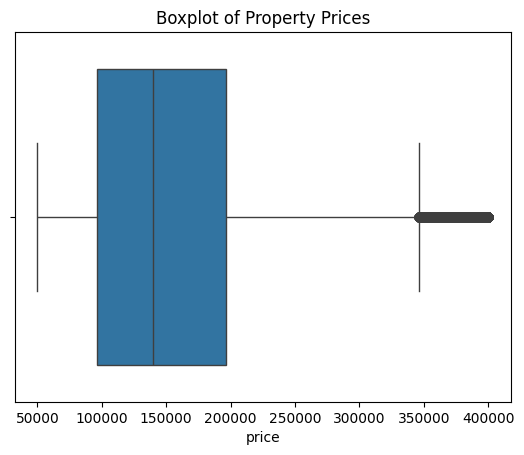

In [38]:
# create box plot to view outliers
sns.boxplot(x=cleaned_final_df['price'])
plt.title('Boxplot of Property Prices')
plt.show()